<h1 align=center><font size = 5>Venues related to income</font></h1>

## Project description 
For this project I want to know if there is a relationship between the average
income in a city area and the number and types of venue
around the same area. 
This can be interesting because we can come with some sociological hypothesis 
and some ideas about what kinds if businesses work in certain areas.



## Data 


The data used related to the average income in a particular zone is taken from the government page, and for the venues info we will use Foursquare Data.

### 1.- Get the data

In [1]:
!pip install BeautifulSoup4
!pip install lxml
!pip install requests
!pip install geopy
!pip install tabula-py

     |████████████████████████████████| 122kB 6.5MB/s eta 0:00:01
     |████████████████████████████████| 5.5MB 7.8MB/s eta 0:00:01
     |████████████████████████████████| 122kB 4.8MB/s eta 0:00:01
     |████████████████████████████████| 10.4MB 7.4MB/s eta 0:00:01


In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np

In [3]:
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium # map rendering library
import json
from pandas import json_normalize

I have downloaded Houston city average income per county data from the government web page and uploaded to my labs, I have named the file hdata, the following code is for reading the data csv:

In [4]:
dfHouston=pd.read_csv('hdata.csv',skiprows=2)
#the first two rows contain the title
dfHouston

,SN #,Super Neighborhood Name,Median Income,Unnamed: 3
0,1,Willowbrook,"$36,498",NaN
1,2,Greater Greenspoint,"$27,334",NaN
2,3,Carverdale,"$56,139",NaN
3,4,Fairbanks,"$37,278",NaN
4,5,Greater Inwood,"$39,086",NaN
...,...,...,...,...
84,85,Spring Branch Central,"$36,252",NaN
85,86,Spring Branch East,"$43,397",NaN
86,87,Greenway,"$77,323",NaN
87,88,Lawndale,"$33,168",NaN


### 2.- Sort and clean the data frame

In [5]:
#Here I drop the last column of the df that contains Nan and the last row
dfHouston=dfHouston.drop(axis=0,index=88)
dfHouston

,SN #,Super Neighborhood Name,Median Income,Unnamed: 3
0,1,Willowbrook,"$36,498",NaN
1,2,Greater Greenspoint,"$27,334",NaN
2,3,Carverdale,"$56,139",NaN
3,4,Fairbanks,"$37,278",NaN
4,5,Greater Inwood,"$39,086",NaN
...,...,...,...,...
83,84,Spring Branch North,"$43,795",NaN
84,85,Spring Branch Central,"$36,252",NaN
85,86,Spring Branch East,"$43,397",NaN
86,87,Greenway,"$77,323",NaN


In [6]:
#I will drop the SN and the Unnamed 3 column
dfHouston=dfHouston.drop(labels=['SN #','Unnamed: 3'],axis=1)
#Lest change the name of the columns for an easier name
dfHouston.columns=['Neighborhood','Avg_income']
dfHouston.head()

,Neighborhood,Avg_income
0,Willowbrook,"$36,498"
1,Greater Greenspoint,"$27,334"
2,Carverdale,"$56,139"
3,Fairbanks,"$37,278"
4,Greater Inwood,"$39,086"


In [7]:
#Lets celan the df from na values
dfHouston=dfHouston.dropna()

Once we have loaded the data regarding the income and the county, we need to get the coordinates of each county with geopy

### 3.- Get latitudes and locations for each neigborhood

In [8]:
from geopy.geocoders import Nominatim
import time

In [9]:
def gloc (names):
    geolocator = Nominatim(user_agent='carreraciro@yahoo.com')
    location=pd.DataFrame(columns=['Latitude','Longitude'])
    i=0
    for name in names:
        loc = geolocator.geocode('{}, Houston, Texas, EE.UU.'.format(name))
        if loc is not None:
            latitude=loc.latitude
            longitude=loc.longitude
            location.loc[i,['Latitude']]=latitude
            location.loc[i,['Longitude']]=longitude
        time.sleep(1)#the timer is needed becouse geocode limits 1 request per sec
        i=i+1
    return (location)

In [10]:
location=gloc(names=dfHouston['Neighborhood'])
location

,Latitude,Longitude
0,29.6603,-95.4561
1,29.9447,-95.4161
2,29.8487,-95.5395
3,29.8527,-95.5244
5,29.7708,-95.3281
...,...,...
83,29.8851,-98.4197
84,29.7999,-95.5112
85,29.8851,-98.4197
86,29.7144,-95.3861


In [11]:
dfHouston1=dfHouston.join(location)
pd.set_option('display.max_rows', 88)
dfHouston1

,Neighborhood,Avg_income,Latitude,Longitude
0,Willowbrook,"$36,498",29.6603,-95.4561
1,Greater Greenspoint,"$27,334",29.9447,-95.4161
2,Carverdale,"$56,139",29.8487,-95.5395
3,Fairbanks,"$37,278",29.8527,-95.5244
4,Greater Inwood,"$39,086",NaN,NaN
5,Acres Home,"$32,053",29.7708,-95.3281
6,Hidden Valley,"$52,462",32.957,-96.4717
7,Westbranch,"$63,397",29.8395,-95.5515
8,Addicks Park Ten,"$53,157",NaN,NaN
9,Spring Branch West,"$49,761",29.8014,-95.5479


Sadly, there are some neighborhoods for which no location was recovered, we need to drop this rows.

In [12]:
dfHouston1=dfHouston1.dropna()

In [13]:
#Get location and longitude of the city of Houston TX
address='Houston, TX'
geolocator = Nominatim(user_agent="tr_explorer")
locationhou = geolocator.geocode(address)
latitude = locationhou.latitude
longitude = locationhou.longitude
print('The geograpical coordinate of the city of Houston are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of the city of Houston are 29.7589382, -95.3676974.


In [14]:
# create map of Houston using latitude and longitude values
map_Houston = folium.Map(location=[latitude, longitude], zoom_start=9.5)
# add markers to map according to the latitude and longitude for each couny
for lat, lng, county in zip(dfHouston1['Latitude'], dfHouston1['Longitude'], dfHouston1['Neighborhood']):
    label = '{}'.format(county)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Houston)  
    
map_Houston

The coordinates recovered with geopy, as we can see from the map above, are not correct, at least the majority is not. I will try again with another library to recover the coordinates of the neighborhoods.

In [15]:
!pip install opencage

In [16]:
from opencage.geocoder import OpenCageGeocode

In [17]:
key = 'c7312a48cdf24612b857aaa9dfcfec87' # get api key from:  https://opencagedata.com
geocoder = OpenCageGeocode(key)

In [18]:
def gloc2 (names):
    location=pd.DataFrame(columns=['Latitude','Longitude'])
    i=0
    for name in names:
        loc = geocoder.geocode('{}, Houston, Texas'.format(name))
        if loc is not None:
            latitude=loc[0]['geometry']['lat']
            longitude=loc[0]['geometry']['lng']
            location.loc[i,['Latitude']]=latitude
            location.loc[i,['Longitude']]=longitude
        i=i+1
    return (location)

In [19]:
location2=gloc2(names=dfHouston['Neighborhood'])
location2

,Latitude,Longitude
0,29.6603,-95.4561
1,29.9447,-95.4161
2,29.8487,-95.5395
3,29.8527,-95.5244
4,29.8805,-96.8058
5,32.5081,-94.6865
6,32.957,-96.4717
7,29.8395,-95.5515
8,29.8692,-95.5666
9,29.8014,-95.5479


In [20]:
dfHouston2=dfHouston.join(location2)
pd.set_option('display.max_rows', 88)
dfHouston2

,Neighborhood,Avg_income,Latitude,Longitude
0,Willowbrook,"$36,498",29.6603,-95.4561
1,Greater Greenspoint,"$27,334",29.9447,-95.4161
2,Carverdale,"$56,139",29.8487,-95.5395
3,Fairbanks,"$37,278",29.8527,-95.5244
4,Greater Inwood,"$39,086",29.8805,-96.8058
5,Acres Home,"$32,053",32.5081,-94.6865
6,Hidden Valley,"$52,462",32.957,-96.4717
7,Westbranch,"$63,397",29.8395,-95.5515
8,Addicks Park Ten,"$53,157",29.8692,-95.5666
9,Spring Branch West,"$49,761",29.8014,-95.5479


In [21]:
dfHouston2=dfHouston2.dropna()

In [22]:
# create map of Houston using latitude and longitude values
map_Houston2 = folium.Map(location=[latitude, longitude], zoom_start=9.5)
# add markers to map according to the latitude and longitude for each couny
for lat, lng, county in zip(dfHouston2['Latitude'], dfHouston2['Longitude'], dfHouston2['Neighborhood']):
    label = '{}'.format(county)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Houston2)  
map_Houston2

Once again the coordinates retrieved are not as accurate as we need them. Thus, I have decided to manually recover the coordinates fro, wikipedia and and them to an excel file which I will upload as a csv and open it. I also took the liberty to change the format in the average income column.

In [23]:
dfHou=pd.read_csv('Hlocation.csv',skiprows=2)
dfHou

,SN #,Super Neighborhood Name,Median Income,Latitude,Longitude
0,1,Willowbrook,36498,29.9547,-95.5513
1,2,Greater Greenspoint,27334,29.9359,-95.4508
2,3,Carverdale,56139,29.8535,-95.5453
3,4,Fairbanks / Northwest Crossing,37278,29.8527,-95.5266
4,5,Greater Inwood,39086,29.8600,-95.4900
...,...,...,...,...,...
84,85,Spring Branch Central,36252,29.8111,-95.5131
85,86,Spring Branch East,43397,29.8026,-95.4755
86,87,Greenway / Upper Kirby Area,77323,29.7329,-95.4331
87,88,Lawndale / Wayside,33168,29.7250,-95.3109


In [24]:
##Lets clean the dataframe again
#Here I drop the last row
dfHou=dfHou.drop(axis=0,index=88)
#I will drop the SN column
dfHou=dfHou.drop(labels=['SN #',],axis=1)
#Lest change the name of the columns for an easier name
dfHou.columns=['Neighborhood','Avg_income','Latitude','Longitude']
#Lets celan the df from na values
dfHou=dfHou.dropna()
dfHou.head()

,Neighborhood,Avg_income,Latitude,Longitude
0,Willowbrook,36498,29.9547,-95.5513
1,Greater Greenspoint,27334,29.9359,-95.4508
2,Carverdale,56139,29.8535,-95.5453
3,Fairbanks / Northwest Crossing,37278,29.8527,-95.5266
4,Greater Inwood,39086,29.8600,-95.4900


Now that we have the data frame with the right coordinates we can make a real Houston neighborhood map

In [25]:
# create map of Houston using latitude and longitude values
map_Houstonok = folium.Map(location=[latitude, longitude], zoom_start=9.5)
# add markers to map according to the latitude and longitude for each couny
for lat, lng, county in zip(dfHou['Latitude'], dfHou['Longitude'], dfHou['Neighborhood']):
    label = '{}'.format(county)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Houstonok)  
map_Houstonok

This map makes much more sense than the others, we can safely say its right. Now we can proceed to get the info of the venues in the neighborhoods.

### 4.- Recover the venue info for each location/neigborhood

In [26]:
#Foursquare credentials info
CLIENT_ID = 'T0ZU0YPBVFJ4TQPF5CPQFW4CO2LYYR11R3A2E5ZA1Z4Y0QR1' # your Foursquare ID
CLIENT_SECRET = 'GNKQPGI1WA101PZLO1W3R5JELYRMXQNCVSUQQDIZKSBDB0NA' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: T0ZU0YPBVFJ4TQPF5CPQFW4CO2LYYR11R3A2E5ZA1Z4Y0QR1
CLIENT_SECRET:GNKQPGI1WA101PZLO1W3R5JELYRMXQNCVSUQQDIZKSBDB0NA


In [27]:
def getNearbyVenues(names, latitudes, longitudes, radius=1250,LIMIT=100):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)     
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)  
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [29]:
H_venues = getNearbyVenues(names=dfHou['Neighborhood'],latitudes=dfHou['Latitude'],longitudes=dfHou['Longitude']) #Runs the function for Houston

Willowbrook
Greater Greenspoint
Carverdale
Fairbanks / Northwest Crossing
Greater Inwood
Acres Home
Hidden Valley
Westbranch
Addicks Park Ten
Spring Branch West
Langwood
Central Northwest
Independence Heights
Lazybrook / Timbergrove
Greater Heights
Memorial
Eldridge / West Oaks
Briar Forest
Westchase
Mid West
Greater Uptown
Washington Avenue Coalition / Memorial Park
Afton Oaks / River Oaks Area
Neartown - Montrose
Alief
Sharpstown
Gulfton
University Place
Westwood
Braeburn
Meyerland Area
Braeswood
Medical Center Area
Astrodome Area
South Main
Brays Oaks
Westbury
Willow Meadows / Willowbend Area
Fondren Gardens
Central Southwest
Fort Bend Houston
IAH / Airport Area
Kingwood Area
Lake Houston
Northside/Northline
Eastex - Jensen Area
East Little York / Homestead
Trinity / Houston Gardens
East Houston
Settegast
Near Northside
Kashmere Gardens
El Dorado / Oates Prairie
Hunterwood
Greater Fifth Ward
Denver Harbor / Port Houston
Pleasantville Area
Northshore
Clinton Park Tri-Community
Fourth

After we ran the previous function we have all the venues in the different neighborhoods in Houston, the head of the list is shown next.

In [30]:
print(H_venues.shape)
H_venues.dropna()
print(H_venues.shape)
H_venues.head()

(3352, 7)
(3352, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Willowbrook,29.9547,-95.5513,Costco,29.954658,-95.547697,Warehouse Store
1,Willowbrook,29.9547,-95.5513,REI,29.957922,-95.547228,Sporting Goods Shop
2,Willowbrook,29.9547,-95.5513,Babin's Seafood House,29.955088,-95.544452,Seafood Restaurant
3,Willowbrook,29.9547,-95.5513,Mint Thai Kitchen,29.956060,-95.544430,Thai Restaurant
4,Willowbrook,29.9547,-95.5513,Bed Bath & Beyond,29.953517,-95.543865,Furniture / Home Store


Now lets group and count the venues for each neighborhood

In [31]:
Hvgroup=H_venues.groupby('Neighborhood').count()
Hvgroup.head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Acres Home,8,8,8,8,8,8
Addicks Park Ten,48,48,48,48,48,48
Afton Oaks / River Oaks Area,22,22,22,22,22,22
Alief,47,47,47,47,47,47
Astrodome Area,91,91,91,91,91,91


In [32]:
print('There are {} uniques categories.'.format(len(H_venues['Venue Category'].unique())))

There are 307 uniques categories.


Now we will analyze each neighborhood.
To start we will create a matrix containing each venue category

In [33]:
# one hot encoding
H_onehot = pd.get_dummies(H_venues[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
H_onehot['Neighborhood'] = H_venues['Neighborhood'] 
# move neighborhood column to the first column
fixed_columns = [H_onehot.columns[-1]] + list(H_onehot.columns[:-1])
H_onehot = H_onehot[fixed_columns]
#Groups rows by neighborhood
H_grouped = H_onehot.groupby('Neighborhood').mean().reset_index()
H_grouped.head()

,Neighborhood,Yoga Studio,ATM,Accessories Store,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Acres Home,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
1,Addicks Park Ten,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.020833,0.0,0.0,0.000000,0.0,0.0,0.0
2,Afton Oaks / River Oaks Area,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
3,Alief,0.0,0.0,0.0,0.0,0.021277,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.170213,0.0,0.0,0.000000,0.0,0.0,0.0
4,Astrodome Area,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.010989,0.010989,0.000000,0.0,0.0,0.010989,0.0,0.0,0.0


In [34]:
H_grouped.shape

(87, 307)

Lets get the 5 most common venues for each neighborhood

In [35]:
num_top_venues = 5
for hood in H_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = H_grouped[H_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Acres Home----
            venue  freq
0            Park  0.25
1     Coffee Shop  0.12
2    Home Service  0.12
3  Baseball Field  0.12
4   Grocery Store  0.12


----Addicks Park Ten----
                venue  freq
0               Hotel  0.29
1         Coffee Shop  0.06
2                Café  0.04
3      Sandwich Place  0.04
4  Mexican Restaurant  0.04


----Afton Oaks / River Oaks Area----
                             venue  freq
0          New American Restaurant  0.09
1                             Park  0.09
2  Southern / Soul Food Restaurant  0.05
3                      Gas Station  0.05
4                        Bookstore  0.05


----Alief----
                   venue  freq
0  Vietnamese Restaurant  0.17
1                   Café  0.06
2            Gas Station  0.06
3       Asian Restaurant  0.06
4                   Park  0.04


----Astrodome Area----
                  venue  freq
0      Football Stadium  0.04
1  Fast Food Restaurant  0.03
2            Sports Bar  0.03
3    Mexic

The next step is to sort the venues in descending order

In [36]:
#This function sorts the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False) 
    return row_categories_sorted.index.values[0:num_top_venues]

In [37]:
#Code to create a database containing each neighborhood an its top ten venue types
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
# create a new dataframe
Hvenues_sorted = pd.DataFrame(columns=columns)
Hvenues_sorted['Neighborhood'] = H_grouped['Neighborhood']
for ind in np.arange(H_grouped.shape[0]):
    Hvenues_sorted.iloc[ind, 1:] = return_most_common_venues(H_grouped.iloc[ind, :], num_top_venues)
Hvenues_sorted.dropna()
Hvenues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Acres Home,Park,Baseball Field,Convenience Store,Home Service,Grocery Store,Coffee Shop,Fried Chicken Joint,Exhibit,Eastern European Restaurant,Electronics Store
1,Addicks Park Ten,Hotel,Coffee Shop,Mexican Restaurant,Sandwich Place,Café,Italian Restaurant,Chinese Restaurant,New American Restaurant,Rental Car Location,Sushi Restaurant
2,Afton Oaks / River Oaks Area,Park,New American Restaurant,Pet Store,Golf Course,Fast Food Restaurant,Pharmacy,Southern / Soul Food Restaurant,Flower Shop,Shipping Store,Food Truck
3,Alief,Vietnamese Restaurant,Gas Station,Asian Restaurant,Café,Massage Studio,Noodle House,Fried Chicken Joint,Bubble Tea Shop,Park,Discount Store
4,Astrodome Area,Football Stadium,Mexican Restaurant,Rental Car Location,Fast Food Restaurant,Sports Bar,BBQ Joint,Mobile Phone Shop,Coffee Shop,Liquor Store,Spa


### 5.- Cluster the neighborhoods

Now we need to cluster the neighborhoods to see which ones are similar and which ones are different


In [38]:
import matplotlib.pyplot as plt

In [39]:
H_grouped.dropna()

,Neighborhood,Yoga Studio,ATM,Accessories Store,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Acres Home,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
1,Addicks Park Ten,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,...,0.00,0.000000,0.000000,0.020833,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
2,Afton Oaks / River Oaks Area,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
3,Alief,0.00,0.00,0.000000,0.000000,0.021277,0.00,0.00,0.00,0.00,...,0.00,0.000000,0.000000,0.170213,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
4,Astrodome Area,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,...,0.00,0.010989,0.010989,0.000000,0.000000,0.000000,0.010989,0.00,0.000000,0.000000
5,Braeburn,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
6,Braeswood,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
7,Brays Oaks,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,...,0.00,0.000000,0.000000,0.000000,0.043478,0.000000,0.000000,0.00,0.000000,0.000000
8,Briar Forest,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,...,0.00,0.000000,0.034483,0.034483,0.000000,0.000000,0.000000,0.00,0.034483,0.000000
9,Carverdale,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000


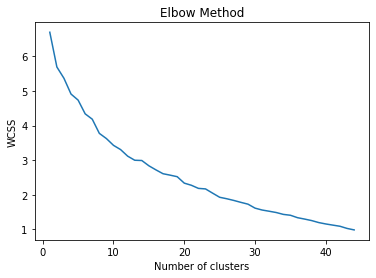

In [40]:
wcss = []
#H_grouped.drop(index=[43,51,56,64],inplace=True)
#I have decided to drop these column becouse no venue data was recovered from them , and this can affect the study
H_grouped_clustering_test = H_grouped.drop('Neighborhood', 1)
for i in range(1,45):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0).fit(H_grouped_clustering_test)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 45), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Using the elbow method we conclude that the best number of cluster is 10, where the inertia changes from behaving like a a curve into a line

In [41]:
# set number of clusters
kclusters = 10
H_grouped_clustering = H_grouped.drop('Neighborhood', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, init='k-means++', max_iter=300, n_init=10, random_state=0).fit(H_grouped_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 5, 0, 3, 5, 5, 0, 0, 3, 5], dtype=int32)

Now we will create a new data frame that contain the cluster and the top ten venues 

In [42]:
# add clustering labels
#Hvenues_sorted.drop(index=[43,51,56,64],inplace=True)
Hvenues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
H_merged = dfHou#.drop(index=[43,51,56,64],inplace=True)
# merge H_grouped with dfHou to add latitude/longitude for each neighborhood
H_merged = H_merged.join(Hvenues_sorted.set_index('Neighborhood'), on='Neighborhood')
H_merged.head() # check the last columns!
H_merged.dropna()

,Neighborhood,Avg_income,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Willowbrook,36498,29.9547,-95.551300,5.0,Furniture / Home Store,Chinese Restaurant,Hotel,American Restaurant,Women's Store,Burger Joint,Fast Food Restaurant,Mobile Phone Shop,Restaurant,Sushi Restaurant
1,Greater Greenspoint,27334,29.9359,-95.450800,3.0,Vietnamese Restaurant,Mexican Restaurant,Bakery,Gas Station,Convenience Store,Intersection,Food,Seafood Restaurant,Food Truck,Fried Chicken Joint
2,Carverdale,56139,29.8535,-95.545300,5.0,Burger Joint,Gas Station,Paper / Office Supplies Store,American Restaurant,Taco Place,Home Service,BBQ Joint,Breakfast Spot,Locksmith,Auto Garage
3,Fairbanks / Northwest Crossing,37278,29.8527,-95.526600,3.0,Convenience Store,Wings Joint,Men's Store,Business Service,Bakery,Café,BBQ Joint,Gas Station,Shoe Store,Sports Bar
4,Greater Inwood,39086,29.8600,-95.490000,3.0,Fast Food Restaurant,Discount Store,Pharmacy,Convenience Store,Cajun / Creole Restaurant,Paper / Office Supplies Store,Gas Station,Bank,Other Repair Shop,Ice Cream Shop
5,Acres Home,32053,29.8619,-95.446000,0.0,Park,Baseball Field,Convenience Store,Home Service,Grocery Store,Coffee Shop,Fried Chicken Joint,Exhibit,Eastern European Restaurant,Electronics Store
6,Hidden Valley,52462,29.8937,-95.420600,3.0,Fast Food Restaurant,Discount Store,Food Truck,Pharmacy,Pizza Place,Donut Shop,Video Store,Fried Chicken Joint,Intersection,Sandwich Place
7,Westbranch,63397,29.8393,-95.551800,5.0,Hotel,Café,Gym / Fitness Center,Auto Garage,Clothing Store,Burrito Place,BBQ Joint,Taco Place,New American Restaurant,Restaurant
8,Addicks Park Ten,53157,29.7822,-95.642200,5.0,Hotel,Coffee Shop,Mexican Restaurant,Sandwich Place,Café,Italian Restaurant,Chinese Restaurant,New American Restaurant,Rental Car Location,Sushi Restaurant
9,Spring Branch West,49761,29.8161,-95.517700,3.0,Vietnamese Restaurant,Pharmacy,Grocery Store,Discount Store,Sandwich Place,Coffee Shop,Burger Joint,Mexican Restaurant,Food Truck,Fried Chicken Joint


Lets create a map that show the clusters



In [43]:
H_merged['Cluster Labels'] = H_merged['Cluster Labels'].fillna(0).astype(int)
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(H_merged['Latitude'],H_merged['Longitude'], H_merged['Neighborhood'], H_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

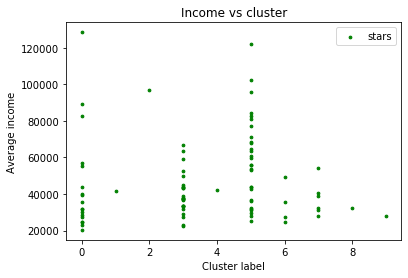

In [44]:
# x axis values 
x = H_merged['Cluster Labels']
# corresponding y axis values 
y = H_merged['Avg_income']
# plotting the points  
plt.scatter(x, y, label= "stars", color= "green", marker= ".", s=30)
# naming the x axis 
plt.xlabel('Cluster label') 
# naming the y axis 
plt.ylabel('Average income') 
# giving a title to my graph 
plt.title('Income vs cluster')
# showing legend 
plt.legend() 
# function to show the plot 
plt.show() 

Sadly, from  the graph above we can say that there is no relationship between the income of a neighborhood and the type of venues. In the same clusters where high income neighborhoods appear, low income ones do appear as well.

Also, we can see that the majority of neighborhoods are contained in cluster labels 0, 3 and 5; lets see what we can find in the majority of neighborhoods in Houston.

In [45]:
H_merged.loc[H_merged['Cluster Labels'] == 0, H_merged.columns[[1] + list(range(5, H_merged.shape[1]))]]

,Avg_income,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,32053,Park,Baseball Field,Convenience Store,Home Service,Grocery Store,Coffee Shop,Fried Chicken Joint,Exhibit,Eastern European Restaurant,Electronics Store
11,55403,Park,Liquor Store,Burger Joint,Discount Store,Trail,Cosmetics Shop,Convenience Store,Supermarket,Supplement Shop,Electronics Store
12,24764,Intersection,Park,Pie Shop,General Entertainment,Business Service,Supplement Shop,Gas Station,Garden,Discount Store,Karaoke Bar
21,89474,Park,Convenience Store,Playground,Breakfast Spot,Boat or Ferry,Sports Club,Sports Bar,Sporting Goods Shop,Baseball Field,Spa
22,128594,Park,New American Restaurant,Pet Store,Golf Course,Fast Food Restaurant,Pharmacy,Southern / Soul Food Restaurant,Flower Shop,Shipping Store,Food Truck
31,82535,Gym,Coffee Shop,Park,Trail,Fried Chicken Joint,Snack Place,Bank,Bakery,Supermarket,Donut Shop
35,39558,Pizza Place,Grocery Store,Home Service,Construction & Landscaping,Discount Store,Clothing Store,Nightclub,Sandwich Place,School,Fast Food Restaurant
36,57058,Construction & Landscaping,Coffee Shop,Donut Shop,Supermarket,Dive Bar,Tennis Court,Theater,Grocery Store,Baseball Field,Gas Station
39,43914,Salon / Barbershop,Playground,Home Service,Nightclub,Food Truck,Grocery Store,Basketball Court,Art Gallery,Museum,Women's Store
54,20326,Park,Pharmacy,Sandwich Place,Discount Store,Intersection,Bus Stop,Gas Station,Arts & Entertainment,Bank,Music Venue


We can say that cluster label 0 contains neighborhoods with parks and other venues.

In [49]:
H_merged.loc[H_merged['Cluster Labels'] == 3, H_merged.columns[[1] + list(range(5, H_merged.shape[1]))]]

,Avg_income,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,27334,Vietnamese Restaurant,Mexican Restaurant,Bakery,Gas Station,Convenience Store,Intersection,Food,Seafood Restaurant,Food Truck,Fried Chicken Joint
3,37278,Convenience Store,Wings Joint,Men's Store,Business Service,Bakery,Café,BBQ Joint,Gas Station,Shoe Store,Sports Bar
4,39086,Fast Food Restaurant,Discount Store,Pharmacy,Convenience Store,Cajun / Creole Restaurant,Paper / Office Supplies Store,Gas Station,Bank,Other Repair Shop,Ice Cream Shop
6,52462,Fast Food Restaurant,Discount Store,Food Truck,Pharmacy,Pizza Place,Donut Shop,Video Store,Fried Chicken Joint,Intersection,Sandwich Place
9,49761,Vietnamese Restaurant,Pharmacy,Grocery Store,Discount Store,Sandwich Place,Coffee Shop,Burger Joint,Mexican Restaurant,Food Truck,Fried Chicken Joint
16,63552,Fast Food Restaurant,Sandwich Place,Clothing Store,Cosmetics Shop,Gas Station,Mexican Restaurant,Shoe Store,Discount Store,Donut Shop,Spa
17,66608,Mexican Restaurant,Grocery Store,Sandwich Place,Burger Joint,Bank,Pizza Place,Bookstore,Seafood Restaurant,Mediterranean Restaurant,Fast Food Restaurant
24,38076,Vietnamese Restaurant,Gas Station,Asian Restaurant,Café,Massage Studio,Noodle House,Fried Chicken Joint,Bubble Tea Shop,Park,Discount Store
25,33180,Bubble Tea Shop,Mexican Restaurant,Spa,Vietnamese Restaurant,Chinese Restaurant,Dessert Shop,Noodle House,Video Store,Pizza Place,Golf Course
28,22448,Fast Food Restaurant,Mobile Phone Shop,Fried Chicken Joint,Gas Station,Grocery Store,Asian Restaurant,Chinese Restaurant,Mexican Restaurant,Filipino Restaurant,Bus Station


The cluster label 3 contains mostly fast food restaurants

In [48]:
H_merged.loc[H_merged['Cluster Labels'] == 5, H_merged.columns[[1] + list(range(5, H_merged.shape[1]))]]

,Avg_income,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,36498,Furniture / Home Store,Chinese Restaurant,Hotel,American Restaurant,Women's Store,Burger Joint,Fast Food Restaurant,Mobile Phone Shop,Restaurant,Sushi Restaurant
2,56139,Burger Joint,Gas Station,Paper / Office Supplies Store,American Restaurant,Taco Place,Home Service,BBQ Joint,Breakfast Spot,Locksmith,Auto Garage
7,63397,Hotel,Café,Gym / Fitness Center,Auto Garage,Clothing Store,Burrito Place,BBQ Joint,Taco Place,New American Restaurant,Restaurant
8,53157,Hotel,Coffee Shop,Mexican Restaurant,Sandwich Place,Café,Italian Restaurant,Chinese Restaurant,New American Restaurant,Rental Car Location,Sushi Restaurant
10,29729,Hotel,Pizza Place,Bank,Fast Food Restaurant,Sandwich Place,Gas Station,Baseball Field,Pet Store,Mexican Restaurant,Cajun / Creole Restaurant
13,56039,Hotel,American Restaurant,Gas Station,Restaurant,Bar,Pizza Place,Gym,Sandwich Place,Lounge,Korean Restaurant
14,67693,Park,Coffee Shop,Mexican Restaurant,Burger Joint,New American Restaurant,Gym / Fitness Center,Flower Shop,Trail,Gift Shop,Pharmacy
15,102600,Clothing Store,Burger Joint,Cosmetics Shop,Bakery,Mexican Restaurant,Steakhouse,Mediterranean Restaurant,Fast Food Restaurant,Shoe Store,Toy / Game Store
18,42705,Hotel,Sandwich Place,Chinese Restaurant,Bakery,Coffee Shop,Gas Station,Pizza Place,Sushi Restaurant,Furniture / Home Store,Taco Place
19,43992,Mexican Restaurant,Pizza Place,Sandwich Place,Bank,Mobile Phone Shop,Fast Food Restaurant,American Restaurant,Middle Eastern Restaurant,Coffee Shop,Rental Car Location


The cluster label 5 contains neighborhoods with Hotels and coffee shops as characterisitc venues.

## Conclusion

We did not manage to find a relationship nor a model that could predict the type of venues (cluster label) of a neighborhood based on the average income of it, but we can still recover a few things from the project. 
First we manage to explore some data analysis tools and some of the things python is capable of a little big further. 
I encountered with a lot of problems while gathering the data, now I understand the importance of having a good source and a good data base, otherwise you can encounter "garbage in,garbage out" problems.
We now know that the neighborhoods in Houston can be divided in 3 principal categories based on their venues, 1.-The neighbours that contain parks, 2.- the ones that contain fast food restaurants and 3.- the ones containing Hotels, coffee shops and bars.
It can be interesting to, at some point, re-do this analysis but with the population of the neighborhood instead than with the average income.

In [ ]:
#We need to take out the word "County" to make the lat and long search
#dfNeigh = dfHouston['Neighborhood'].str.replace(' /','')
#dfNeigh = dfNeigh.str.replace(' -','')
#dfNeigh=dfNeigh.to_frame() #converts the series into a df
#dfNeigh

In [ ]:
#Now we join the two dataframes and rearange it in the order we want
#dfHouston=dfHouston.drop(labels='Neighborhood',axis=1).join(dfNeigh,how='left')
#dfHouston=dfHouston[['Neighborhood','Avg_income']]
#pd.set_option('display.max_rows', 88)
#dfHouston

In [ ]:
#convert the link into a txet
#link = requests.get("https://en.wikipedia.org/wiki/List_of_Houston_neighborhoods").text
#Creates a soup object
#soup = BeautifulSoup(link, 'lxml')

In [ ]:
#using soup object cretes a list ftom the "wikitable"
#data = []
#columns = []
#table = soup.find(class_='wikitable')
#for index, tr in enumerate(table.find_all('tr')):
#    section = []
#    for td in tr.find_all(['th','td']):
#        section.append(td.text.rstrip())
#    
    #First row of data is the header
#    if (index == 0):
#        columns = section
#    else:
#        data.append(section)

In [ ]:
#convert list into Pandas DataFrame
#dfhn = pd.DataFrame(data = data,columns = columns)
#dfhn.head()

In [ ]:
#dfhn=dfhn.drop(labels=['#','Name','Location relative to Downtown Houston'],axis=1)
#dfhn

In [ ]:
#dfHouston=dfHouston.join(dfhn)
#pd.set_option('display.max_rows', 88)
#dfHouston